In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)

# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# import tensorflow as tf
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import AUC

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("lending_club_loan_two.csv")
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.00,Not Verified,Jan-15,Fully Paid,vacation,Vacation,26.24,Jun-90,16,0,36369,41.80,25,w,INDIVIDUAL,0.00,0.00,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.00,Not Verified,Jan-15,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-04,17,0,20131,53.30,27,f,INDIVIDUAL,3.00,0.00,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.00,Source Verified,Jan-15,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-07,13,0,11987,92.20,26,f,INDIVIDUAL,0.00,0.00,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.00,Not Verified,Nov-14,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-06,6,0,5472,21.50,13,f,INDIVIDUAL,0.00,0.00,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.00,Verified,Apr-13,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-99,13,0,24584,69.80,43,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\r\nGreggshire, VA 11650"


In [7]:
df = data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  int64  
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

- Looks like we'll have to deal with some nulls
- Data types look appropriate
    - emp_length should be int
    - issue_d is month loan issued, could be changed to date
    - earliest_cr_line is month first credit issued
    

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.00,14113.89,8357.44,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.00,13.64,4.47,5.32,10.49,13.33,16.49,30.99
installment,396030.00,431.85,250.73,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.00,74203.18,61637.62,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.00,17.38,18.02,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.00,11.31,5.14,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.00,0.18,0.53,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.00,15844.54,20591.84,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.00,53.79,24.45,0.00,35.80,54.80,72.90,892.30
total_acc,396030.00,25.41,11.89,2.00,17.00,24.00,32.00,151.00


In [9]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [28]:
(df.isnull().sum()/df.shape[0]*100)[:] # Percentage of nulls in each column

loan_amnt              0.00
term                   0.00
int_rate               0.00
installment            0.00
grade                  0.00
sub_grade              0.00
emp_title              5.79
emp_length             4.62
home_ownership         0.00
annual_inc             0.00
verification_status    0.00
issue_d                0.00
loan_status            0.00
purpose                0.00
title                  0.44
dti                    0.00
earliest_cr_line       0.00
open_acc               0.00
pub_rec                0.00
revol_bal              0.00
revol_util             0.07
total_acc              0.00
initial_list_status    0.00
application_type       0.00
mort_acc               9.54
pub_rec_bankruptcies   0.14
address                0.00
dtype: float64

- explore the emp_title and emp_length


In [43]:
df.emp_title.value_counts()

Teacher                    4389
Manager                    4250
Registered Nurse           1856
RN                         1846
Supervisor                 1830
                           ... 
sikorsky                      1
Postman                       1
McCarthy & Holthus, LLC       1
jp flooring                   1
Gracon Services, Inc          1
Name: emp_title, Length: 173103, dtype: int64

- 173k different employment titles, will drop col for ease of use

In [39]:
df.emp_length.value_counts()

10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
9 years       15314
Name: emp_length, dtype: int64

In [42]:
for year in df.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{df[df.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('~~~~~~~~~~')

10+ years years in this position:
Fully Paid    0.82
Charged Off   0.18
Name: loan_status, dtype: float64
~~~~~~~~~~
4 years years in this position:
Fully Paid    0.81
Charged Off   0.19
Name: loan_status, dtype: float64
~~~~~~~~~~
< 1 year years in this position:
Fully Paid    0.79
Charged Off   0.21
Name: loan_status, dtype: float64
~~~~~~~~~~
6 years years in this position:
Fully Paid    0.81
Charged Off   0.19
Name: loan_status, dtype: float64
~~~~~~~~~~
9 years years in this position:
Fully Paid    0.80
Charged Off   0.20
Name: loan_status, dtype: float64
~~~~~~~~~~
2 years years in this position:
Fully Paid    0.81
Charged Off   0.19
Name: loan_status, dtype: float64
~~~~~~~~~~
3 years years in this position:
Fully Paid    0.80
Charged Off   0.20
Name: loan_status, dtype: float64
~~~~~~~~~~
8 years years in this position:
Fully Paid    0.80
Charged Off   0.20
Name: loan_status, dtype: float64
~~~~~~~~~~
7 years years in this position:
Fully Paid    0.81
Charged Off   0.19
Name: l

- loan status value counts across all the length of employment times is about the same, can be dropped

In [37]:
df.title.value_counts(normalize=True)

Debt consolidation           0.39
Credit card refinancing      0.13
Home improvement             0.04
Other                        0.03
Debt Consolidation           0.03
                             ... 
PayOffHighIntCreditCards     0.00
Heat my home                 0.00
Graduation/Travel Expenses   0.00
Daughter's Wedding Bill      0.00
Toxic Debt Payoff            0.00
Name: title, Length: 48790, dtype: float64

In [45]:
df.purpose.value_counts()

debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: purpose, dtype: int64

- drop title, according to data dictionary, title is customer description of loan purpose, also represented in purpose feature

- drop revol_util, less than .1% null

- mortage accounts has nearly 10% nulls
    - needs further exploration to impute appropriately

In [47]:
df.mort_acc.value_counts()

0.00     139777
1.00      60416
2.00      49948
3.00      38049
4.00      27887
5.00      18194
6.00      11069
7.00       6052
8.00       3121
9.00       1656
10.00       865
11.00       479
12.00       264
13.00       146
14.00       107
15.00        61
16.00        37
17.00        22
18.00        18
19.00        15
20.00        13
24.00        10
22.00         7
21.00         4
25.00         4
27.00         3
32.00         2
31.00         2
23.00         2
26.00         2
28.00         1
30.00         1
34.00         1
Name: mort_acc, dtype: int64

In [48]:
df.mort_acc.isna().sum()

37795

In [62]:
df.mort_acc.describe()

count   358235.00
mean         1.81
std          2.15
min          0.00
25%          0.00
50%          1.00
75%          3.00
max         34.00
Name: mort_acc, dtype: float64

<AxesSubplot:xlabel='mort_acc'>

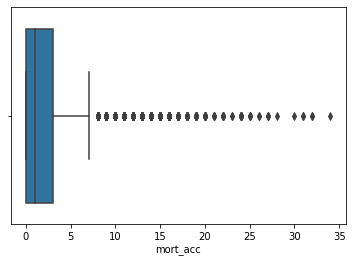

In [67]:
sns.boxplot(df.mort_acc)

<AxesSubplot:xlabel='mort_acc', ylabel='Density'>

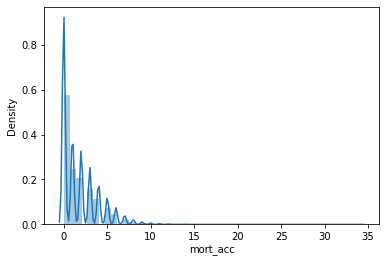

In [66]:
sns.distplot(df.mort_acc)

 - based on the boxplot and the distplot, I think imputing the value of 2 would  be the best approach (mean:1.8, median:1)

In [68]:
df['mort_acc'] = df['mort_acc'].fillna("2", inplace = True)

In [70]:
df[df.pub_rec_bankruptcies > 0]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
10,10000,36 months,13.11,337.47,B,B4,Sodexo,2 years,RENT,95000.00,Verified,Jun-13,Fully Paid,debt_consolidation,Debt Consolidation,12.04,Dec-90,5,1,4702,64.40,26,f,INDIVIDUAL,None,1.00,"40245 Cody Drives\r\nBartlettfort, NM 00813"
17,11200,60 months,12.29,250.79,C,C1,principal,10+ years,MORTGAGE,81000.00,Not Verified,Oct-15,Fully Paid,debt_consolidation,Debt consolidation,12.87,Sep-96,6,1,5874,54.90,20,w,INDIVIDUAL,None,1.00,487 Jennifer Parkway Suite 940\r\nCummingsshir...
35,5375,36 months,13.11,181.39,B,B4,NaN,NaN,RENT,34000.00,Verified,May-13,Fully Paid,credit_card,Pay Off Credit Card,26.12,Apr-98,9,1,14998,88.70,20,f,INDIVIDUAL,None,1.00,"23617 Michael Viaduct\r\nWest John, MS 05113"
55,15000,36 months,13.98,512.52,C,C3,Armored Car Guard,3 years,OWN,40000.00,Not Verified,Oct-14,Fully Paid,debt_consolidation,Debt consolidation,14.55,Jan-06,4,1,9207,51.70,9,w,INDIVIDUAL,None,1.00,"6360 Claire Motorway\r\nEast Shannonchester, A..."
95,30000,36 months,16.49,1061.99,D,D3,Sergeant Major,10+ years,RENT,101000.00,Verified,Nov-14,Fully Paid,debt_consolidation,Debt consolidation,15.76,Jun-03,7,1,6080,76.00,15,f,INDIVIDUAL,None,1.00,"2528 Herrera Track Suite 897\r\nSavannahburgh,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395963,7000,36 months,20.20,260.86,E,E3,NaN,NaN,OWN,32964.00,Verified,Jun-14,Fully Paid,medical,Medical expenses,6.33,Jan-04,24,1,3236,9.70,44,w,INDIVIDUAL,None,1.00,8339 Daniel Forges Suite 273\r\nPort Oscarmout...
395982,6000,36 months,12.99,202.14,B,B5,owner,2 years,MORTGAGE,50000.00,Verified,Apr-14,Fully Paid,debt_consolidation,Debt consolidation,18.17,May-98,10,1,11011,66.70,26,w,INDIVIDUAL,None,1.00,"405 Melissa Well Apt. 054\r\nNorth Josephside,..."
395990,12000,36 months,13.44,406.88,C,C3,teacher,10+ years,MORTGAGE,69400.00,Source Verified,Jan-16,Fully Paid,debt_consolidation,Debt consolidation,14.01,Aug-00,13,1,10782,58.60,28,w,INDIVIDUAL,None,1.00,"162 Wright Lock\r\nNorth Timmouth, OH 00813"
395998,10000,36 months,14.16,342.56,C,C2,Sales Representative,< 1 year,OWN,55000.00,Verified,Apr-14,Fully Paid,debt_consolidation,Debt consolidation,16.47,Feb-76,18,1,11513,44.00,51,f,INDIVIDUAL,None,1.00,"996 Samuel Lake\r\nSouth Williammouth, NH 05113"


- there are 45115 records with pub_rec_bankruptcies > 0
- total, 395495
- .14% of the total records are null, assuming the ratio would continue, that would account for 63 additional pub rec bankruptcies.
- so we will just drop nulls

### Cleanup Summary
    - drop columns of emp_title, emp_length, title
    - drop rows with null values in col revol_util, pub_rec_bankruptcies
    - impute nulls with value of 2 in mort_acc feature based on boxplot/distplots
    -create clean_lending() function

In [76]:
def clean_lending(df):
    #drop unneeded columns
    df = df.drop(['emp_title'], axis=1)
    df = df.drop(['emp_length'], axis=1)
    df = df.drop(['title'], axis=1)
    
    #impute
    df['mort_acc'] = df['mort_acc'].fillna("2", inplace = True)
    
    #drop small amount of nulls
    df = df.dropna()
    
    return df    

In [77]:
#validate
df = clean_lending(df)
df.isnull().sum()

loan_amnt              0.00
term                   0.00
int_rate               0.00
installment            0.00
grade                  0.00
sub_grade              0.00
home_ownership         0.00
annual_inc             0.00
verification_status    0.00
issue_d                0.00
loan_status            0.00
purpose                0.00
dti                    0.00
earliest_cr_line       0.00
open_acc               0.00
pub_rec                0.00
revol_bal              0.00
revol_util             0.00
total_acc              0.00
initial_list_status    0.00
application_type       0.00
mort_acc               0.00
pub_rec_bankruptcies   0.00
address                0.00
dtype: float64

In [ ]:
##rename some columns for ease of use
    df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "sqft","taxvaluedollarcnt": "home_value"})
    
#remove homes with zero beds
    df = df[df.bedrooms != 0]
    
##filled null/Nonetype with 'None' or '0'
    df.heatingorsystemdesc = df.heatingorsystemdesc.fillna('None')
    df.airconditioningdesc = df.airconditioningdesc.fillna('None')
    df.poolcnt = df.poolcnt.fillna('0')
    df.garagecarcnt = df.garagecarcnt.fillna('0')
    
#feature engineering
    df['home_value_structure_tax_difference'] = (df['home_value']-df['structuretaxvaluedollarcnt'])
    df['hvs_pct'] = (df['home_value_structure_tax_difference']/df['home_value'])
    df['taxrate'] = (df['taxamount']/df['home_value'])
    df['age'] = 2017 - df.yearbuilt
    df['cost_per_sqft'] = (df['home_value']/df['sqft']).round(2)
    df['sqft_room_ratio'] = (df['sqft']/(df['bedrooms']+df['bathrooms'])).round(2)
    mapping = {"None" : "0",
                     "Central" : "2",
                     "Yes" : "1",
                     "Wall Unit" : "1",
                     }
    df['airconditioning_encoded'] = df['airconditioningdesc'].map(mapping)

#impute nulls with tax rate mean times home value
    df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(df['home_value']*df['hvs_pct'].mean())
    
#impute 4 missing values for taxamount using mean taxrate of feature engineering
    df.taxamount = df.taxamount.fillna(df['home_value']*df['taxrate'].mean())
    
#impute nulls with regionidcity mode of 12447
    df['regionidcity'] = df.regionidcity.fillna(12447)
    
#impute missing values with below
    df.home_value_structure_tax_difference = df.home_value_structure_tax_difference.fillna(df['home_value']-df['structuretaxvaluedollarcnt'])
    
#impute missing values with below
    df.hvs_pct = df.hvs_pct.fillna(df['home_value_structure_tax_difference']/df['home_value'])
    
#impute nulls with mean year built
    df.yearbuilt = df.yearbuilt.fillna(df['yearbuilt'].mean())
    
#impute nulls with mode of regionidzip
    df.regionidzip = df.regionidzip.fillna(df.regionidzip.mode())
    
##replace nulls with median lot size
    df.lotsizesquarefeet = df.lotsizesquarefeet.fillna(df.lotsizesquarefeet.median())
    
##impute fullbathcnt with value from df.bathrooms
    df.fullbathcnt = df.fullbathcnt.fillna(df.bathrooms)                                                   
                                                       
##drop remaining handful of nulls
    df = df.dropna()                                                   
    return df